# 5章 リカレントニューラルネットワーク(RNN)

## 5.1 確率と言語モデル

### 5.1.1 word2vecを確率の視点から眺める

### 5.1.2 言語モデル

#### 言語モデル
単語の並びに対してそれがどれだけ起こりえるのかという確率を与える．この確率は音声認識や機械翻訳が文章として自然であるかどうかを判断する際などに用いることができる．
#### 同時確率
$$
P(w_1, ..., w_m)
$$
複数の事象が同時に起こる確率
#### 同時確率を事後確率で分解する
$$
P(w_1, ..., w_m) = P(w_m|w_1, ..., w_{m-1})P(w_{m-1}|w_1, ..., w_{m-2})
...P(w_3|w_1, w_2)P(w_2|w_1)P(w_1)
= \prod_{t=1}^{m}P(w_t|w_1, ..., w_{t-1})
$$

### 5.1.3 CBOWモデルを言語モデルに？

コンテキストのサイズをある値に限定することで近似的に表す．

#### word2vecのCBOWモデルを言語モデルに
### $$ 
P(w_1, ..., w_m) = \prod_{t=1}^{m}P(w_t|w_1, ..., w_{t-1})～\prod_{t=1}^{m}P(w_t|w_{t-2}, w_{t-1})
$$

#### マルコフ性
未来の状態が現在の状態だけに依存して決まること．ある事象の確率がその直前のN個の事象だけに依存するとき，「N階マルコフ連鎖」と言う．
#### CBOWモデルはコンテキスト内の単語の並びを無視する
CBOWモデルの中間層では単語ベクトルの和が求められるため，コンテキストの単語の並び方が無視される．

コンテキストの単語ベクトルを中間層において「連結」することが考えられる．一方で連結するアプローチをとれば，コンテキストのサイズに比例して重みパラメータが増える．それは歓迎されない．

#### RNN
上のジレンマを解消するのがRNN（リカレントニューラルネットワーク）である．

## 5.2 RNNとは

#### 直訳すると．．．
何度も繰り返し起こること，再発するニューラルネットワーク，循環するニューラルネットワーク．
る．

### 5.2.1 循環するニューラルネットワーク

#### 閉じた経路を持つ
ループ経路を持つことで，データは絶えず循環することができる．そしてデータが循環することにより，過去の情報を記憶しながら，最新のデータへと更新され

### 5.2.2 ループの展開

#### 2つの入力（そのレイヤの入力，一つ前のRNNレイヤからの出力）を元にその時刻の出力が計算される
### $$
h_1 = tanh(h_{t-1}W_h+x_tW_x+b)
$$

- $W_x$: 入力xを出力hに変換するための重み
- $W_h$: ひとつ前のRNNの出力を次時刻の出力に変換するための重み
- $b$: バイアス

#### 状態を持つレイヤ，メモリ（記憶力）を持つレイヤ
RNNはhという状態を持つ．

#### 隠れ状態，隠れ状態ベクトル
RNNのhは「状態」を記憶し，時間が1ステップ（1単位）進むに従い，上記の式の形で計算が行われて更新していく．

### 5.2.3 Backpropagation Through Time

#### BPTT
Backpropagation Through Timeの略称．ループを展開した後のRNNは（通常の）誤差逆伝播法を使える．ここでの誤差逆伝播法は，「時間方向に展開したニューラルネットワークの誤差逆伝播法」となる．

#### RNNの学習時の問題
時系列データの時間サイズが大きくなると同時に，BPTTで消費するコンピュータの計算リソースが増加すること．また時間サイズが長くなれば，逆伝播時の勾配が不安定になることも考えられる．時系列データの長さに応じて増加するコンピュータのメモリ使用量も考える必要がある．

### 5.2.4 Truncated BPTT

#### Truncated BPTT
時間軸方向に長くなり過ぎたネットワークを適当な場所で切り取ることで，小さなネットワークを（複数）作るというアイデア．そして，その切り取った小さなネットワークに対して，誤差逆伝播法を行う．

#### データをシーケンシャルに与える
順伝播のつながりを維持させながら，ブロック単位で誤差逆伝播法を適用する．

### 5.2.5 Truncated BPTTのミニバッチ学習

ミニバッチ学習を行う場合は，各バッチの開始位置をオフセットとしてずらして，シーケンシャルに与えていく．シーケンシャルにデータを与えていく途中で終端に達した場合は，先頭に戻すような対応が必要．

## 5.3 RNNの実装

- RNNレイヤ：Time RNNレイヤ内の1ステップの処理を行うレイヤ
- Time RNNレイヤ：Tステップ分の処理をまとめて行うレイヤ
- <code>class RNN</code>：RNNの1ステップの処理を行うクラス
- <code>class TimeRNN</code>：RNNクラスを利用して，Tステップの処理をまとめて行うクラス

### 5.3.1 RNNレイヤの実装

In [2]:
# NumPy
import numpy as np

# RNNクラス
class RNN:
    # 初期化，コンストラクタ
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh),\
                     np.zeros_like(b)]
        self.chache = None
        
    # 順伝播
    def forward(self, x, h_prev):
        Wx, Wh, b = self.params
        t = np.dot(h_prev, Wh) + np.dot(x, Wx) + b
        h_next = np.tanh(t)
        
        self.chache = (x, h_prev, h_text)
        return h_next
    
    # 逆伝播
    def backward(self, dh_next):
        Wx, Wh, b = self.params
        x, h_prev, h_next = self.chache
        
        dt = dh_next * (1 - h_next ** 2)
        db = np.sum(dt, axis=0)
        dWh = np.dot(h_prev.T, dt)
        dh_prev = np.dot(dt, Wh.T)
        dWx = np.dot(x.T, dt)
        dx = np.dot(dt, Wx.T)
        
        self.grads[0][...] = dWx
        self.grads[1][...] = dWh        
        self.grads[2][...] = db
        
        return dx, dh_prev

### 5.3.2 Time RNNレイヤの実装

#### 隠れ状態h
Time RNNクラスのメンバ変数に保持する．隠れ状態の引継ぎを行う際に使用する．

In [4]:
# Time RNN
class TimeRNN:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh),
                     np.zeros_like(b)]
        self.layers = None
        
        self.h, self.dh = None, None
        self.stateful = stateful
        
    def set_state(self, h):
        self.h = h
        
    def reset_state(self):
        self.h = None
    
    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        D, H = Wx.shape
        
        self.layers = []
        hs = np.empty((N, T, H), dtype='f')
        
        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')
            
        for t in range(T):
            layer = RNN(*self.params)
            self.h = layer.forward(xs[:, t, :], self.h)
            hs[:, t, :] = self.h
            self.layers.append(layer)
            
        return hs
    
    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D, H = Wx.shape
        
        dxs = np.empty((N, T, D), dtype='f')
        dh = 0
        grads = [0, 0, 0]
        for i in reversed(range(T)):
            layer = self.layers[t]
            dx, dh = layer.backward(dhs[:, t, :] + dh)  # 合算した勾配
            dxs[:, t, :] = dx
            
            for i, grad in enumerate(layer.grads):
                grads[i] += grad
                
        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh
        
        return dxs

長い時系列データを処理するとき，RNNの隠れ状態を維持する必要がある．このような隠れ状態を維持する機能は，statefulという言葉でよく表される．多くのディープラーニングのフレームワークでは，RNNレイヤの引数にstatefulというものがあり，前時刻の隠れ状態を保持するかどうか指定することができる．

## 5.4 時系列データを扱うレイヤの実装

#### RNNLMの完成を目指す
RNN Language Modelを作成する．

### 5.4.1 RNNLMの全体図

RNNLMはこれまで入力された単語を記憶し，それを元に次に出現する単語を予測する．これを可能にしているのがRNNレイヤの存在．RNNレイヤが過去から現在へとデータを継続して流すことによって，過去の情報をエンコードして記憶することを可能にしている．

### 5.4.2 Timeレイヤの実装

## 5.5 RNNLMの学習と評価

### 5.5.1 RNNLMの実装

#### SimpleRnnlmクラス
4つのTimeレイヤを重ねたニューラルネットワーク．

In [5]:
# SimpleRnnlm
# coding: utf-8
import sys
sys.path.append('..')
import numpy as np
from common.time_layers import *


class SimpleRnnlm:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 重みの初期化
        embed_W = (rn(V, D) / 100).astype('f')
        rnn_Wx = (rn(D, H) / np.sqrt(D)).astype('f')
        rnn_Wh = (rn(H, H) / np.sqrt(H)).astype('f')
        rnn_b = np.zeros(H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        # レイヤの生成
        self.layers = [
            TimeEmbedding(embed_W),
            TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.rnn_layer = self.layers[1]

        # すべての重みと勾配をリストにまとめる
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, ts):
        for layer in self.layers:
            xs = layer.forward(xs)
        loss = self.loss_layer.forward(xs, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.rnn_layer.reset_state()


### 5.5.2 言語モデルの評価

#### パープレキシティ
言語モデルでは，過去の与えられた単語（情報）から次に出現する単語の確率分布を出力するが，このときに言語モデルの予測性能の良さを評価する指標．確率の逆数がそれに該当する．パープレキシティの値は小さければ小さい程良い．値を直観的に解釈するなら分岐数と考えると分かりやすい．

#### パープレキシティの数式
### $$
L = -\frac{1}{N}\sum_{n}\sum_{k}t_{nk}logy_{nk}
$$
$$
perplexity = e^L
$$

情報理論の分野では，パープレキシティは「平均分岐数」とも呼ばれる．これは，データが1個のときに説明した「分岐数」をN個の場合で平均したものという解釈．

### 5.5.3 RNNLMの学習コード

corpus size: 1000, vocabulary size: 418
| epoch 1 | perplexity 394.52
| epoch 2 | perplexity 274.94
| epoch 3 | perplexity 226.20
| epoch 4 | perplexity 216.44
| epoch 5 | perplexity 206.20
| epoch 6 | perplexity 203.45
| epoch 7 | perplexity 200.09
| epoch 8 | perplexity 196.90
| epoch 9 | perplexity 191.31
| epoch 10 | perplexity 192.36
| epoch 11 | perplexity 187.80
| epoch 12 | perplexity 191.65
| epoch 13 | perplexity 189.31
| epoch 14 | perplexity 190.27
| epoch 15 | perplexity 188.82
| epoch 16 | perplexity 185.41
| epoch 17 | perplexity 183.38
| epoch 18 | perplexity 179.26
| epoch 19 | perplexity 180.24
| epoch 20 | perplexity 181.45
| epoch 21 | perplexity 179.00
| epoch 22 | perplexity 174.53
| epoch 23 | perplexity 171.50
| epoch 24 | perplexity 173.54
| epoch 25 | perplexity 171.29
| epoch 26 | perplexity 169.70
| epoch 27 | perplexity 164.24
| epoch 28 | perplexity 162.68
| epoch 29 | perplexity 158.91
| epoch 30 | perplexity 153.10
| epoch 31 | perplexity 154.13
| epoch 

findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.


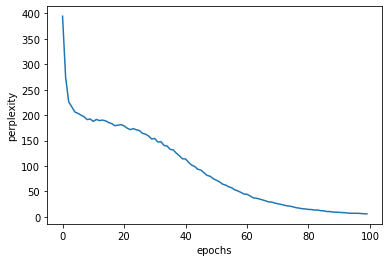

In [7]:
# coding: utf-8
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
import numpy as np
from common.optimizer import SGD
from dataset import ptb



# ハイパーパラメータの設定
batch_size = 10
wordvec_size = 100
hidden_size = 100
time_size = 5  # Truncated BPTTの展開する時間サイズ
lr = 0.1
max_epoch = 100

# 学習データの読み込み（データセットを小さくする）
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)

xs = corpus[:-1]  # 入力
ts = corpus[1:]  # 出力（教師ラベル）
data_size = len(xs)
print('corpus size: %d, vocabulary size: %d' % (corpus_size, vocab_size))

# 学習時に使用する変数
max_iters = data_size // (batch_size * time_size)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

# モデルの生成
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)

# ミニバッチの各サンプルの読み込み開始位置を計算
jump = (corpus_size - 1) // batch_size
offsets = [i * jump for i in range(batch_size)]

for epoch in range(max_epoch):
    for iter in range(max_iters):
        # ミニバッチの取得
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size]
                batch_t[i, t] = ts[(offset + time_idx) % data_size]
            time_idx += 1

        # 勾配を求め、パラメータを更新
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1

    # エポックごとにパープレキシティの評価
    ppl = np.exp(total_loss / loss_count)
    print('| epoch %d | perplexity %.2f'
          % (epoch+1, ppl))
    ppl_list.append(float(ppl))
    total_loss, loss_count = 0, 0

# グラフの描画
x = np.arange(len(ppl_list))
plt.plot(x, ppl_list, label='train')
plt.xlabel('epochs')
plt.ylabel('perplexity')
plt.show()


### 5.5.4 RNNLMのTrainerクラス

## 5.6 まとめ

#### 本章で学んだこと
- RNNはループする経路があり，それによって隠れ状態を内部に記憶することができる
- RNNのループ経路を展開することで，複数のRNNレイヤがつながったネットワークと解釈することができ，通常の誤差逆伝播法によって学習することができる(=BPTT)
- 長い時系列データを学習する場合は，適当な長さでデータのまとまりを作り，-これを「ブロック」という-,ブロック単位でBPTTによる学習を行う(=Trancated BPTT)
- Truncated BPTTでは逆伝播のつながりのみを切断する
- Trancated BPTTでは順伝播のつながりは維持するため，データはシーケンシャルに与える必要がある
- 言語モデルは，単語の羅列を確率として解釈する
- RNNレイヤを利用した条件付き言語モデルは，（理論的には）それまで登場した単語の情報を記憶することができる．